In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo.gates import M, RY, CZ, I, H
from qibo.models import Circuit
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration
from scipy import stats
from benchmarks.utils.qst_qpt_helper_functions import process_returned_dataformat
from time import sleep
import matplotlib

from itertools import product
api = API(ConnectionConfiguration(username="vsanchez", api_key="ea712370-7516-4cbf-91a6-72a82e39ba02"))
import logging

api.select_device_id(9)

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.ERROR)

/home/victor/qilimanjaro/qiboconnection-portfolio/benchmarks/utils/qst_qpt_helper_functions.py:107: DeprecationWarning:invalid escape sequence '\o'
/home/victor/qilimanjaro/qiboconnection-portfolio/benchmarks/utils/qst_qpt_helper_functions.py:202: DeprecationWarning:invalid escape sequence '\o'
/home/victor/envs/qililab/lib/python3.10/site-packages/qiboconnection/api.py:217: UserWarning:This method is deprecated and will be removed in the following Qiboconnection release. Use device_id argument in execute() method instead.


### Experiment parameters

In [2]:
CONTROL_QUBIT = 0
TARGET_QUBIT = 2
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "phi_plus" # phi_plus, phi_minus, psi_plus, psi_minus

NUM_SHOTS = 8000
result_id = 9536

LOAD_RESULTS = True
mfidelity_qc = 0.882 # measurement fidelity control qubit
mfidelity_qt = 0.875 # measurement fidelity target qubit

### Circuits definitions

In [3]:
def get_chsh_circuits(bell_state, control_qubit, target_qubit, theta):
    assert bell_state in (
        "phi_plus",
        "phi_minus",
        "psi_plus",
        "psi_minus",
    ), "bell_state should be phi_plus, phi_minus, psi_plus, psi_minus"
    nqubits = max(control_qubit, target_qubit) + 1

    circuits = []
    for gate_a, gate_b in product([I, H], repeat=2):
        circuit = Circuit(nqubits)

        if bell_state == "phi_plus" or bell_state == "psi_minus":
            G1 = RY(control_qubit, theta=-np.pi / 2)
        else:
            G1 = RY(control_qubit, theta=np.pi / 2)
        if bell_state == "phi_plus" or bell_state == "phi_minus":
            G2_prime = RY(target_qubit, theta=-np.pi / 2)
        else:
            G2_prime = RY(target_qubit, theta=np.pi / 2)
        ## build bell state
        circuit.add(G1)
        circuit.add(RY(target_qubit, theta=np.pi / 2))
        circuit.add(CZ(control_qubit, target_qubit))
        circuit.add(G2_prime)

        ## decoder part
        circuit.add(RY(control_qubit, theta=theta))
        circuit.add(gate_a(control_qubit))
        circuit.add(gate_b(target_qubit))
        circuit.add(M(control_qubit, target_qubit))

        circuits.append(circuit)

    return circuits

def compute_witnesses(chsh_results, BELL_STATE, ea=1, eb=1, raw=False):
    """Returns arrays of computed witness values.

    Args:
        chsh_results (array): matrix containing the probabilities the chsh circuits. It must be
                        of dimensions len(theta_values) x 4 (decoder circuits) x 4 (probabilities)
        measurement_calibration_weights (array): measurement calibration matrix.
        BELL_STATE (string): can be "phi_plus", "phi_minus", "psi_plus" or "psi_minus". It needs
                            to be specified because the witness isn't the same for all 4 Bell states.
        raw (bool): whether or not calculate the witnesses from the raw data instead of applying the
                    measurement corrections. Defaults to False.
    Returns:
        witness1 (array): array length len(theta_values) containing the first witness
        witness2 (array): array length len(theta_values) containing the second witness
    """
    len_theta_values = np.shape(chsh_results)[0]
    witness1 = np.zeros(len_theta_values)
    witness2 = np.zeros(len_theta_values)

    e_m = np.array([[ea*eb, ea*(1-eb), eb*(1-ea), (1-ea)*(1-eb)],
                    [ea*(1-eb), ea*eb, (1-ea)*(1-eb), eb*(1-ea)],
                    [eb*(1-ea), (1-ea)*(1-eb), ea*eb, ea*(1-eb)],
                    [(1-ea)*(1-eb), ea*(1-eb), eb*(1-ea), ea*eb]])

    if BELL_STATE in ["phi_plus", "psi_minus"]:
        signs1 = np.array([1, 1, -1, 1])
        signs2 = np.array([1, -1, 1, 1])
    else:
        signs1 = np.array([-1, 1, 1, 1])
        signs2 = np.array([1, 1, 1, -1])

    for i, chsh_result in enumerate(chsh_results):
        if raw is not True:
            # apply measurement calibration
            # chsh_result = measurement_calibration_weights @ chsh_result.T
            chsh_result = chsh_result @  np.linalg.inv(e_m)

        # calculate expectation values from probabilities
        expectations = chsh_result @ np.array([1, -1, -1, 1])
        # compute witnesses
        witness1[i] = signs1.T @ expectations
        witness2[i] = signs2.T @ expectations
    return witness1, witness2

### Build circuits for CHSH and measurement correction

In [4]:
all_circuits = []
for theta in THETA_VALUES:
    circuits_th = get_chsh_circuits(BELL_STATE, CONTROL_QUBIT, TARGET_QUBIT, theta)
    all_circuits.extend(circuits_th)

### Run circuits

In [5]:

if LOAD_RESULTS is False:
  result_id = api.execute(all_circuits, nshots=NUM_SHOTS)[0]

### Wait until execution has finished

In [6]:
results = None
while results is None:
    results = api.get_result(result_id)
    sleep(1)
results

/home/victor/envs/qililab/lib/python3.10/site-packages/qiboconnection/api.py:420: UserWarning:This method is deprecated and will be removed in a future qiboconnection version. Use get_job(job_id).result to retrieve your results instead.


[{'probabilities': {'00': 0.2135, '01': 0.33925, '10': 0.33225, '11': 0.115}},
 {'probabilities': {'00': 0.332,
   '01': 0.2285,
   '10': 0.201625,
   '11': 0.237875}},
 {'probabilities': {'00': 0.26225, '01': 0.26625, '10': 0.2605, '11': 0.211}},
 {'probabilities': {'00': 0.134,
   '01': 0.38925,
   '10': 0.392125,
   '11': 0.084625}},
 {'probabilities': {'00': 0.16375,
   '01': 0.38325,
   '10': 0.35775,
   '11': 0.09525}},
 {'probabilities': {'00': 0.366625,
   '01': 0.194125,
   '10': 0.167125,
   '11': 0.272125}},
 {'probabilities': {'00': 0.240875,
   '01': 0.285375,
   '10': 0.286375,
   '11': 0.187375}},
 {'probabilities': {'00': 0.148875, '01': 0.375125, '10': 0.392, '11': 0.084}},
 {'probabilities': {'00': 0.18375,
   '01': 0.377125,
   '10': 0.340375,
   '11': 0.09875}},
 {'probabilities': {'00': 0.412875,
   '01': 0.1495,
   '10': 0.12625,
   '11': 0.311375}},
 {'probabilities': {'00': 0.1915,
   '01': 0.32225,
   '10': 0.328125,
   '11': 0.158125}},
 {'probabilities': {'00

### Process real data

In [7]:
def get_basis_elements_dict(nqubits):
    basis_elements = {}
    for i, x in enumerate(product(['0', '1'], repeat = nqubits)):
        basis_elements[''.join(x)] = i
    return basis_elements

def process_returned_dataformat(results, nqubits=2):
    """Organises the results returned by qiboconnection into a matrix.

    Args:
        results (list): list of result objects returned by qiboconnection
        nqubits (int, optional): number of qubits. Defaults to 2.

    Returns:
        res (array): matrix of dimensions (len(results), 2**nqubits) containing the
                    probabilities with which each bitstring was found for each circuit.
    """
    res = np.zeros((len(results), 2**nqubits))
    basis_elements_dict = get_basis_elements_dict(nqubits)
    for i, result in enumerate(results):
        for key, val in result["probabilities"].items():
            res[i, basis_elements_dict[key]] = val
    return res

In [8]:
## retrieve data
results = api.get_result(result_id)
data_probabilities = process_returned_dataformat(results, nqubits=2)
## compute witness
w1_raw, w2_raw = compute_witnesses(data_probabilities.reshape(len(THETA_VALUES), 4, 4), BELL_STATE, raw=True)
w1_corrected, w2_corrected = compute_witnesses(
    data_probabilities.reshape(len(THETA_VALUES), 4, 4), BELL_STATE, ea=mfidelity_qc, eb=mfidelity_qt, raw=False
)

/home/victor/envs/qililab/lib/python3.10/site-packages/qiboconnection/api.py:420: UserWarning:This method is deprecated and will be removed in a future qiboconnection version. Use get_job(job_id).result to retrieve your results instead.


### Run simulation, get ideal witnesses

In [18]:
circ_list = list(np.copy(all_circuits))
ideal_results_chsh = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_chsh[i] += c.execute().probabilities(qubits=[TARGET_QUBIT, CONTROL_QUBIT])

w1_ideal, w2_ideal = compute_witnesses(
    ideal_results_chsh.reshape(len(THETA_VALUES), 4, 4), BELL_STATE, ea=1, eb=1, raw=False
)

### Get error bars

In [19]:
def return_mock_results(data_probabilities, ea=1, eb=1):
    # returns simulated results using distribution from experimental results' probabilities
    mock_results = np.empty(shape=data_probabilities.shape)
    for i, _ in enumerate(mock_results):
        mock_results[i] = (stats.multinomial.rvs(NUM_SHOTS, data_probabilities[i]) / NUM_SHOTS)

    return list((compute_witnesses(mock_results.reshape(-1, 4, 4), BELL_STATE, ea=mfidelity_qc, eb=mfidelity_qt, raw=False) +
            compute_witnesses(mock_results.reshape(-1, 4, 4), BELL_STATE, raw=True)))

def get_err_bars(mock_results):
    data_hist = np.stack(mock_results)
    err_bars = np.empty(len(data_hist.T))
    for i, hist in enumerate(data_hist.T):
        _ , var = stats.norm.fit(hist)
        err_bars[i] =np.sqrt(var)
    return err_bars

# generate n copies of random results
err_w1, err_w2, err_w1_unc, err_w2_unc  = [get_err_bars(mock_results) for mock_results in zip(*[return_mock_results(data_probabilities, ea=mfidelity_qc, eb=mfidelity_qt) for _ in range(1000)])]

### Plot results

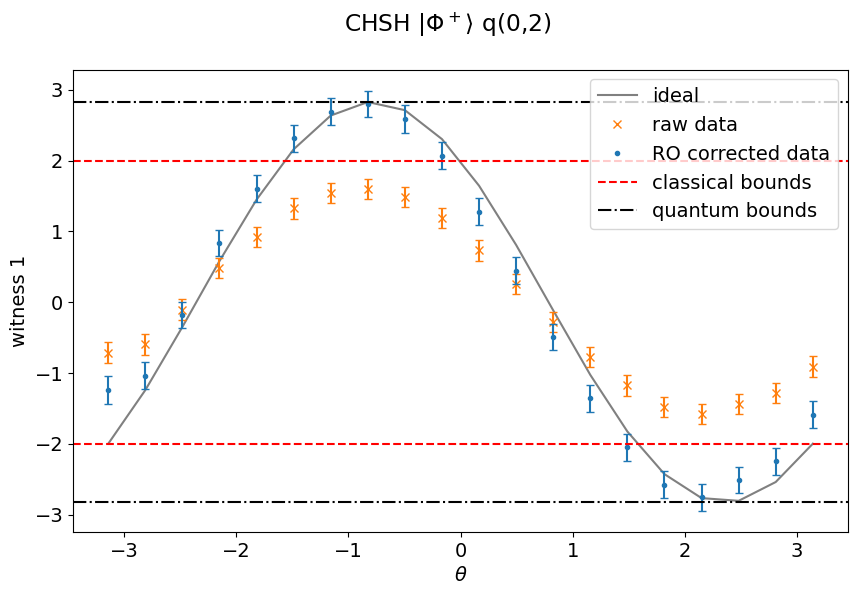

In [20]:
matplotlib.rcParams.update({'font.size': 14})

fname = f"chsh_{CONTROL_QUBIT}_{TARGET_QUBIT}_{BELL_STATE}_nshots{NUM_SHOTS}_jobid{result_id}.png"
savefig = False
bell_names = {"phi_plus": "|$\\Phi^+\\rangle$", "phi_minus": "|$\\Phi^-\\rangle$", "psi_plus": "|$\\Psi^+\\rangle$", "psi_minus": "|$\\Psi^- \\rangle$",}
fig, ax0 = plt.subplots(1, 1, figsize=(10, 6))

# ideal
ax0.plot(THETA_VALUES, w1_ideal, c="grey", label="ideal")
# raw data
ax0.plot(THETA_VALUES, w1_raw, "x", c="C1", label="raw data")
ax0.errorbar(THETA_VALUES, w1_raw, err_w1_unc, capsize=3, c="C1", ls="none")
# corrected data
ax0.plot(THETA_VALUES, w1_corrected, ".", c="C0", label="RO corrected data")
ax0.errorbar(THETA_VALUES, w1_corrected, err_w1, capsize=3, c="C0", ls="none")
ax0.set_ylabel("witness 1")

ax0.axhline(2, color="red", linestyle="--", label="classical bounds")
ax0.axhline(-2, color="red", linestyle="--")
ax0.axhline(2 * np.sqrt(2), color="k", linestyle="-.", label="quantum bounds")
ax0.axhline(-2 * np.sqrt(2), color="k", linestyle="-.")
ax0.set_xlabel("$\\theta$")
ax0.legend()

fig.suptitle(f"CHSH {bell_names[BELL_STATE]} q({CONTROL_QUBIT},{TARGET_QUBIT})")
if savefig:
    fig.savefig(fname, bbox_inches="tight")